In [389]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 14 22:43:07 2020

@author: james }

Utilizes functions from dataloader.py given in the PA1.zip file. Will utilize PCA...
"""
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

''' 
list of face expressions (contempt, neutral are excluded) are:
1. anger
2. disgust
3. fear
4. happiness
5. sadness
6. surprise
'''

def load_data(data_dir="./aligned/"):
	""" Load all PNG images stored in your data directory into a list of NumPy
	arrays.

	Args:
		data_dir: The relative directory path to the CK+ image directory.
	Returns:
		images: A dictionary with keys as emotions and a list containing images associated with each key.
		cnt: A dictionary that stores the # of images in each emotion
	"""
	images = defaultdict(list)

	# Get the list of emotional directory:
	for e in listdir(data_dir):
		# excluding any non-directory files
		if not os.path.isdir(os.path.join(data_dir, e)):
			continue
		# Get the list of image file names
		all_files = listdir(os.path.join(data_dir, e))

		for file in all_files:
			# Load only image files as PIL images and convert to NumPy arrays
			if '.png' in file:
				img = Image.open(os.path.join(data_dir, e, file))
				images[e].append(np.array(img))

	print("Emotions: {} \n".format(list(images.keys())))

	cnt = defaultdict(int)
	for e in images.keys():
		print("{}: {} # of images".format(e, len(images[e])))
		cnt[e] = len(images[e])
	return images, cnt

def balanced_sampler(dataset, cnt, emotions):
	# this ensures everyone has the same balanced subset for model training, don't change this seed value
	random.seed(20)
	print("\nBalanced Set:")
	min_cnt = min([cnt[e] for e in emotions])
	balanced_subset = defaultdict(list)
	for e in emotions:
		balanced_subset[e] = copy.deepcopy(dataset[e])
		random.shuffle(balanced_subset[e])
		balanced_subset[e] = balanced_subset[e][:min_cnt]
		print('{}: {} # of images'.format(e, len(balanced_subset[e])))
	return balanced_subset

def display_face(img):
	""" Display the input image and optionally save as a PNG.

	Args:
		img: The NumPy array or image to display

	Returns: None
	"""
	# Convert img to PIL Image object (if it's an ndarray)
	if type(img) == np.ndarray:
		print("Converting from array to PIL Image")
		img = Image.fromarray(img)

	# Display the image
	img.show()

#INPUT: images and number of k mutually exclusive sets
#OUTPUT: dictionary of k mutually exclusive sets with roughly same number of each category
def CrossFold(dataset,number):
    toReturn = defaultdict(list)
    targets = defaultdict(list)

    image_total=[]
    label_total=[]
    
    labels =[k for k,v in dataset.items()]
    numimages=len([x for x in dataset.values()][0])
    for i in range(numimages):
        for x in labels:
            image_total.append(dataset[x][i])
            label_total.append(x)
    image_split=np.array_split(image_total,number)
    label_split=np.array_split(label_total,number)

    for i in range(len(image_split)):
        toReturn[i]=image_split[i]
        targets[i]=[d[x] for x in label_split[i]]
    return toReturn,targets

def CheckMutuallyExclusive(areMutuallyExclusive):
    for k,v in areMutuallyExclusive.items():
        #within a fold:
        for i in range(len(v)):
            toBeEvaluated = v[i]
            for j in range(i+1, len(v)):
                if(np.array_equal(toBeEvaluated,v[j])):
                    print("Well this sucks I have redundancies within a fold...")
        #between folds:
        for key,value in areMutuallyExclusive.items():
            if k == key:
                continue
            else:
                for i in range(len(v)):
                    for j in range(len(value)):
                        if np.array_equal(v[i], value[j]):
                            print("Son of a.... there are redundancies between folds")
                    
    return None 

#PCA:
    
# Function to convert the Python dictionary loaded in by the dataloader.py load_data function 
# into a NumPy matrix for downstream manipulation
# Params:
# image_dict - Python dictionary with facial expressions as keys and a list NumPy arrays representing
#              image as values
# Return: A NumPy matrix of dimensions dxM denoting M images of d dimensions and the corresponding targets
def get_matrix(image_dict):
    #forTargets = 0
    #correspondingTargets = []
    image_matrix = []
    for emotion in image_dict:
        for image in image_dict[emotion]:
            image_matrix.append(np.concatenate(image))
            #correspondingTargets.append(forTargets)
        #forTargets += 1
    return np.matrix(image_matrix).T #, correspondingTargets

# Function to apply PCA to a dxM image matrix, with M images each of dimension d
# Params:
# image_matrix - a dxM matrix representing M images each of dimension d (output of get_matrix)
# Return: the eigenvalues and principal components of the covariance matrix of the input
# eig_vals - the M eigenvalues of the MxM covariance matrix
# pcs - the M dx1 eigenvectors of the covariance matrix in the form of a dxM matrix
# Return: the M eigenvalues and M pcs from the covariance matrix calculated via PCA
def principal_components(image_matrix):
    mean_face = np.matrix.mean(image_matrix, axis = 1)
    centered_matrix = image_matrix - mean_face
    covariance_matrix = np.dot(centered_matrix.T, centered_matrix)/centered_matrix.shape[1]
    eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)
    order = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[order]
    eig_vecs = eig_vecs[:,order]
    pcs = np.dot(centered_matrix, eig_vecs)
    return(eig_vals, pcs)
    
# Function to project a dxM image matrix onto pcs calculate by PCA
# Params:
# mean_face - the average face calculate from averaging pixel values of training set
# image_matrix - the images to project in the from of a dxM matrix
# eig_vals - the eigenvalues calculated from PCA on the training set
# pcs - the pcs calculated from PCA on the training set
# k - the number of dimensions to keep
# Return: the dxM image matrix projected down to the kxM space
def project_k_dimensions(mean_face, image_matrix, eig_vals, pcs, k):
    centered_matrix = image_matrix - mean_face
    projections = np.dot(centered_matrix.T, pcs[:, 0:k])
    projections = projections/(np.linalg.norm(pcs[:, 0:k], axis = 0))/np.sqrt(eig_vals[0:k])
    return projections.T#[:,0:k].T

#LOGISTIC REGRESSION FUNCTIONS:

#INPUT: List of numpy arrays
#OUTPUT: list of flattened numpy arrays with a 1 to account for bias at the front 
def Transform(aSeriesOfUnfortunateEvents): #Flatten the  numpy arrays and add a bias term to the front
    countOlaf = list()
    for baudelaire in aSeriesOfUnfortunateEvents:
        countOlaf.append(np.concatenate((np.array([1]),baudelaire.flatten())))
    return countOlaf 

def MatrixToListOfTransformedArrays(annoyingMatrix):
    return list(np.squeeze(np.asarray(annoyingMatrix)))

#SOFTMAX REGRESSION FUNCTIONS

#one-hot encoding of y target
def one_hot(y):
    y=np.array(y)
    y_ = np.zeros((y.size, y.max()+1))
    y_[np.arange(y.size),y] = 1
    return(y_)

#define net input of matrix which is dot product of feature matrix and weights
def net_input(X, W):
    return (X.dot(W))

#define softmax function
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

#define functions to convert to class labels
def to_classlabel(z):
    return z.argmax(axis=1)

def cross_entropy(output, y_target):
    return - np.sum(np.log(output) * (y_target),axis=1)

def cost(output, y_target):
    return np.sum(cross_entropy(output, y_target))

def ComputeSigmoidFunction(func):
    if type(func) is np.ndarray:
        func = func[0]
    return 1/(1 + np.exp(-1 * func))

def accuracy(pred, actual):
    count=0
    for x in range(len(pred)):
        if to_classlabel(pred)[x]==to_classlabel(actual)[x]:
            count+=1
        else: pass
    return(count/len(pred))

def BatchGradient(faces, whereDoIBelong, weigh):
    prediction = (np.dot(faces,weigh))
    return np.dot((prediction-whereDoIBelong).T, faces).T

def StochasticGradient(faces, whereDoIBelong, weigh, alpha):
    W = weigh.copy()
    num_weights, num_classes = weigh.shape
    N = np.random.permutation(faces.shape[0])
    for i in N:
        prediction = np.dot(faces[i],W)
        W = W - alpha*np.dot(np.reshape(faces[i], (num_weights, 1)), np.reshape(prediction-whereDoIBelong[i], (1, num_classes)))
    return W


#QUESTION 6c: Weight Visualization
#INPUTS:
#1) A single row of the weights from the softmax activation (np.array)
#2) The principal components 
#3) The number of principal components used for training (int)
#4) The first dimension of the image (224?) (int)
#5) The second dimension of the image (192?) (int)
#6) The emotion associated with these weights (str)
#OUTPUT:
# This function will plot the weight visualization for a particular emotion
# This function will return None
def VisualizeWeights(weights, principalComponents, numPrincipalComponents,uno,dos):
    
    plt.figure(figsize=(12,12))
    plt.title("Weight visualization of " + str(numPrincipalComponents) + " PCs")
    for k in range(6):
        curr_weights = weights[:,k]
        freshPrinceOfBelAir = list()
        for i in range(numPrincipalComponents):
            freshPrinceOfBelAir.append(principalComponents[:, i] * curr_weights[i+1]) #i+1 to skip over the bias weight
        sauronOfMordor = freshPrinceOfBelAir[0]
        for i in range(1, len(freshPrinceOfBelAir)):
            sauronOfMordor += freshPrinceOfBelAir[i]
        minWeight = min(sauronOfMordor)
        maxWeight = max(sauronOfMordor)
        print(minWeight)
        print(maxWeight)
        sauronOfMordor = (sauronOfMordor - minWeight)*(maxWeight/256)*4
        print(min(sauronOfMordor))
        print(max(sauronOfMordor))
                                                        
        plt.subplot(1, 6, k+1)
        forPlotting = np.array(np.reshape(sauronOfMordor, (uno, dos)))
        img = Image.fromarray(forPlotting)
        plt.imshow(img)
        plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
        
     
    return None

In [384]:
# example on how to use it
if __name__ == '__main__':
	# The relative path to your image directory
	data_dir = "./aligned/"
	dataset, cnt = load_data(data_dir)
	# test with happiness and anger
	images = balanced_sampler(dataset, cnt, emotions=['happiness', 'anger',"fear","surprise","sadness","disgust"] )
	display_index = 0
	#display_face(images['anger'][display_index])
#get image categories
images.keys()
#map categories to numeric categories
d = dict([(y,x) for x,y in enumerate(sorted(set(images.keys())))])

Emotions: ['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] 

fear: 25 # of images
surprise: 83 # of images
sadness: 28 # of images
happiness: 69 # of images
anger: 45 # of images
disgust: 59 # of images

Balanced Set:
happiness: 25 # of images
anger: 25 # of images
fear: 25 # of images
surprise: 25 # of images
sadness: 25 # of images
disgust: 25 # of images


## 6ai. Plot loss on training set and holdout set with different subject for test set

In [399]:
def softmax_regression(howManyPrincipalComponents, alpha, k, numEpochs):

    dataset, cnt = load_data("./aligned/")
    images = balanced_sampler(dataset, cnt, emotions=['happiness', 'anger',"fear","surprise","sadness","disgust"])
    
    ##randomly shuffle data to get new test set images##
    [random.shuffle(v) for k,v in images.items()]
    ##Cross fold to get 10 mututally exclusive set##
    splitEmUp, labels = CrossFold(images, k)
    CheckMutuallyExclusive(splitEmUp)    
    
    # For batch
    trainingLossBatch = []
    validationLossBatch = []
    testLossBatch = []

    trainPerformanceBatch = []
    valPerformanceBatch = []
    testPerformanceBatch = []
    
    # For stochastic
    trainingLossStochastic = []
    validationLossStochastic = []
    testLossStochastic = []

    trainPerformanceStochastic = []
    valPerformanceStochastic = []
    testPerformanceStochastic = []
    
    for fold in range(10):
        #Since k is = 10 split into train,val,and test in 80/10/10 
        trainData = defaultdict(list)
        trainLabels = []
        valData = defaultdict(list)
        valLabels = []
        testData = defaultdict(list)
        testLabels = []
        counter = 0 
        
        valData["val"] = splitEmUp[fold]
        testData["test"] = splitEmUp[(fold + 1) %k]
        counter = 0
        for key,v in splitEmUp.items():
            if (counter != fold) and (counter != (fold +1) %k):
                for val in v: 
                    trainData["train"].append(val)
                for el in labels[key]:
                    trainLabels.append(el)
                counter += 1
            elif(counter == fold):
                for el in labels[key]:
                    valLabels.append(el)
                counter += 1 
            else:
                for el in labels[key]:
                    testLabels.append(el)
                counter += 1
        
        if len(testLabels) != len(valLabels):
            print("Strange things are happening")
            
        #Ensure fractions are correct!           
        #print(len(trainData["train"])/len([val for k,v in splitEmUp.items() for val in v]))
        #print(len(valData["val"])/len([val for k,v in splitEmUp.items() for val in v]))
        #print(len(testData["test"])/len([val for k,v in splitEmUp.items() for val in v]))
        
        ##one-hot encode labels##
        trainLabels=one_hot(trainLabels)
        valLabels=one_hot(valLabels)
        testLabels=one_hot(np.array(testLabels))
        
        ##Create X feature matrix based on PCs Principal Components##
        trainingMatrix = get_matrix(trainData)
        eig_vals, pcs = principal_components(trainingMatrix)
        mean_face = np.matrix.mean(trainingMatrix, axis = 1)
        centered_matrix = trainingMatrix - mean_face

        projectedTrain = project_k_dimensions(mean_face, trainingMatrix, eig_vals, pcs, howManyPrincipalComponents).T
        projectedTrain = Transform(MatrixToListOfTransformedArrays(projectedTrain))
        projectedVal = project_k_dimensions(mean_face, get_matrix(valData), eig_vals, pcs, howManyPrincipalComponents).T
        projectedVal = Transform(MatrixToListOfTransformedArrays(projectedVal))
        projectedTest = project_k_dimensions(mean_face, get_matrix(testData), eig_vals, pcs, howManyPrincipalComponents).T
        projectedTest = Transform(MatrixToListOfTransformedArrays(projectedTest))

        projectedTrain=np.array(projectedTrain)
        projectedVal=np.array(projectedVal)
        projectedTest=np.array(projectedTest)

        num_inputs = howManyPrincipalComponents
        num_outputs = len(trainLabels.T)
        
        # Batch Gradient Descent
        train_cost_batch = []
        valid_cost_batch = []
        train_acc_batch = []
        valid_acc_batch = []
        
        weights_batch = np.zeros((howManyPrincipalComponents+1, num_outputs))
        train_cost_batch.append(cost(softmax(net_input(projectedTrain,weights_batch)),np.array(trainLabels))/len(projectedTrain))
        valid_cost_batch.append(cost(softmax(net_input(projectedVal,weights_batch)),np.array(valLabels))/len(projectedVal))
        train_acc_batch.append(accuracy(softmax(net_input(projectedTrain,weights_batch)),trainLabels))
        valid_acc_batch.append(accuracy(softmax(net_input(projectedVal,weights_batch)),valLabels))
        
        suchABatchConversation = weights_batch.copy()
        earlyStop = False
        for ep in range(numEpochs):
            weights_batch = weights_batch - alpha*BatchGradient(projectedTrain, trainLabels, weights_batch)
            
            train_cost_batch.append(cost(softmax(net_input(projectedTrain,weights_batch)),np.array(trainLabels))/len(projectedTrain))
            valid_cost_batch.append(cost(softmax(net_input(projectedVal,weights_batch)),np.array(valLabels)/len(projectedVal)))
            train_acc_batch.append(accuracy(softmax(net_input(projectedTrain,weights_batch)),trainLabels))
            valid_acc_batch.append(accuracy(softmax(net_input(projectedVal,weights_batch)),valLabels))
            
            #early stopping check
            if (valid_cost_batch[len(valid_cost_batch)-1] < valid_cost_batch[len(valid_cost_batch)-2]) and (not earlyStop):
                suchABatchConversation = weights_batch.copy()
            else:
                earlyStop = True
                
        #print(weights_batch)
        trainingLossBatch.append(train_cost_batch)
        trainPerformanceBatch.append(train_acc_batch)
        validationLossBatch.append(valid_cost_batch)
        valPerformanceBatch.append(valid_acc_batch)
        testLossBatch.append(cost(softmax(net_input(projectedTest,suchABatchConversation)),np.array(testLabels))/len(projectedTest))
        testPerformanceBatch.append(accuracy(softmax(net_input(projectedTest,suchABatchConversation)),testLabels))  
    
        # Stochastic Gradient Descent -- NEEDS A GRADIENT FUNCTION
        train_cost_stochastic = []
        valid_cost_stochastic = []
        train_acc_stochastic = []
        valid_acc_stochastic = []

        weights_stochastic = np.zeros((howManyPrincipalComponents+1, num_outputs))
        train_cost_stochastic.append(cost(softmax(net_input(projectedTrain,weights_stochastic)),np.array(trainLabels))/len(projectedTrain))
        valid_cost_stochastic.append(cost(softmax(net_input(projectedVal,weights_stochastic)),np.array(valLabels))/len(projectedVal))
        train_acc_stochastic.append(accuracy(softmax(net_input(projectedTrain,weights_stochastic)),trainLabels))
        valid_acc_stochastic.append(accuracy(softmax(net_input(projectedVal,weights_stochastic)),valLabels))

        suchAStochasticConversation = weights_stochastic.copy()
        earlyStop = False

        for ep in range(numEpochs):
            ####CHANGE HERE
            weights_stochastic = StochasticGradient(projectedTrain, trainLabels, weights_stochastic, alpha)

            train_cost_stochastic.append(cost(softmax(net_input(projectedTrain,weights_stochastic)),np.array(trainLabels))/len(projectedTrain))
            valid_cost_stochastic.append(cost(softmax(net_input(projectedVal,weights_stochastic)),np.array(valLabels)/len(projectedVal)))
            train_acc_stochastic.append(accuracy(softmax(net_input(projectedTrain,weights_stochastic)),trainLabels))
            valid_acc_stochastic.append(accuracy(softmax(net_input(projectedVal,weights_stochastic)),valLabels))

            #early stopping check
            if (valid_cost_stochastic[len(valid_cost_stochastic)-1] < valid_cost_stochastic[len(valid_cost_stochastic)-2]) and (not earlyStop):
                suchAStochasticConversation = weights_stochastic.copy()
            else:
                earlyStop = True 

        #print(weights_stochastic)
        trainingLossStochastic.append(train_cost_stochastic)
        trainPerformanceStochastic.append(train_acc_stochastic)
        validationLossStochastic.append(valid_cost_stochastic)
        valPerformanceStochastic.append(valid_acc_stochastic)

        testLossStochastic.append(cost(softmax(net_input(projectedTest,suchAStochasticConversation)),np.array(testLabels))/len(projectedTest))
        testPerformanceStochastic.append(accuracy(softmax(net_input(projectedTest,suchAStochasticConversation)),testLabels))
    
    print("BATCH")
    print("The average test loss is: " + str(sum(testLossBatch)/len(testLossBatch)) + " (" + str(np.std(testLossBatch)) + ")")
    print("The average test accuracy is: " + str(sum(testPerformanceBatch)*100/len(testPerformanceBatch)) + "% (" + str(np.std(testPerformanceBatch)*100) + ")")
    
    print("STOCHASTIC")
    print("The average test loss is: " + str(sum(testLossStochastic)/len(testLossStochastic)) + " (" + str(np.std(testLossStochastic)) + ")")
    print("The average test accuracy is: " + str(sum(testPerformanceStochastic)*100/len(testPerformanceStochastic)) + "% (" + str(np.std(testPerformanceStochastic)*100) + ")")
    
    print(validationLossBatch[0][25])
    print(validationLossStochastic[0][25])
    
    #6ai 
    trainLossForPlottingBatch = list()
    valLossForPlottingBatch = list()
    
    trainLossForPlottingStochastic = list()
    valLossForPlottingStochastic = list()
    
    trainAccForPlottingBatch = list()
    valAccForPlottingBatch = list()
    
    trainAccForPlottingStochastic = list()
    valAccForPlottingStochastic = list()
    
    for i in range(numEpochs+1):
        tempBatch = list()
        tempStochastic = list()
        for j in range(len(trainingLossBatch)):
            tempBatch.append(trainingLossBatch[j][i])
            tempStochastic.append(trainingLossStochastic[j][i])
        trainLossForPlottingBatch.append([np.mean(tempBatch), np.std(tempBatch)])
        trainLossForPlottingStochastic.append([np.mean(tempStochastic), np.std(tempStochastic)])
        
    for i in range(numEpochs+1):
        tempBatch = list()
        tempStochastic = list()
        for j in range(len(validationLossBatch)):
            tempBatch.append(validationLossBatch[j][i])
            tempStochastic.append(validationLossStochastic[j][i])
        valLossForPlottingBatch.append([np.mean(tempBatch), np.std(tempBatch)])
        valLossForPlottingStochastic.append([np.mean(tempStochastic), np.std(tempStochastic)])
    
    for i in range(numEpochs+1):
        tempBatch = list()
        tempStochastic = list()
        for j in range(len(trainPerformanceBatch)):
            tempBatch.append(trainPerformanceBatch[j][i])
            tempStochastic.append(trainPerformanceStochastic[j][i])
        trainAccForPlottingBatch.append([np.mean(tempBatch), np.std(tempBatch)])
        trainAccForPlottingStochastic.append([np.mean(tempStochastic), np.std(tempStochastic)])
    
    for i in range(numEpochs+1):
        tempBatch = list()
        tempStochastic = list()
        for j in range(len(valPerformanceBatch)):
            tempBatch.append(valPerformanceBatch[j][i])
            tempStochastic.append(valPerformanceStochastic[j][i])
        valAccForPlottingBatch.append([np.mean(tempBatch), np.std(tempBatch)])
        valAccForPlottingStochastic.append([np.mean(tempStochastic), np.std(tempStochastic)])

    #Create validation and train plots:
    plt.figure(figsize=(12,10))
    plt.subplot(2,1,1)
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainLossForPlottingBatch],'b', label = "train")
    plt.errorbar([i for i in range(10,60,10)], [trainLossForPlottingBatch[i][0] for i in range(10, len(trainLossForPlottingBatch)) if i%10 == 0],yerr = [trainLossForPlottingBatch[i][1]/2 for i in range(10, len(trainLossForPlottingBatch)) if i%10 == 0], fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in valLossForPlottingBatch], 'r--' , label = "val")
    plt.errorbar([i for i in range(10,60,10)], [valLossForPlottingBatch[i][0] for i in range(10, len(valLossForPlottingBatch)) if i%10 == 0],yerr = [valLossForPlottingBatch[i][1]/2 for i in range(10, len(valLossForPlottingBatch)) if i%10 == 0], fmt = "ro", alpha = 0.55)
    plt.title("Loss and Accuracy for Aligned " + ": "+ str(howManyPrincipalComponents)+  " PCs and Learning Rate " + str(alpha))
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainAccForPlottingBatch], 'b', label = "train")
    plt.errorbar([i for i in range(10,60,10)], [trainAccForPlottingBatch[i][0] for i in range(10, len(trainAccForPlottingBatch)) if i%10 == 0],yerr = [trainAccForPlottingBatch[i][1]/2 for i in range(10, len(trainAccForPlottingBatch)) if i%10 == 0], fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in valAccForPlottingBatch], 'r--', label = "val")
    plt.errorbar([i for i in range(10,60,10)], [valAccForPlottingBatch[i][0] for i in range(10, len(valAccForPlottingBatch)) if i%10 == 0],yerr = [valAccForPlottingBatch[i][1]/2 for i in range(10, len(valAccForPlottingBatch)) if i%10 == 0], fmt = "ro", alpha = 0.55)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.figure(figsize=(12,10))
    plt.subplot(2,1,1)
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainLossForPlottingStochastic],'b', label = "train")
    plt.errorbar([i for i in range(10,60,10)], [trainLossForPlottingStochastic[i][0] for i in range(10, len(trainLossForPlottingStochastic)) if i%10 == 0],yerr = [trainLossForPlottingStochastic[i][1]/2 for i in range(10, len(trainLossForPlottingStochastic)) if i%10 == 0], fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in valLossForPlottingStochastic], 'r--' , label = "val")
    plt.errorbar([i for i in range(10,60,10)], [valLossForPlottingStochastic[i][0] for i in range(10, len(valLossForPlottingStochastic)) if i%10 == 0],yerr = [valLossForPlottingStochastic[i][1]/2 for i in range(10, len(valLossForPlottingStochastic)) if i%10 == 0], fmt = "ro", alpha = 0.55)
    plt.title("Loss and Accuracy for Aligned " + ": "+ str(howManyPrincipalComponents)+  " PCs and Learning Rate " + str(alpha))
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainAccForPlottingStochastic], 'b', label = "train")
    plt.errorbar([i for i in range(10,60,10)], [trainAccForPlottingStochastic[i][0] for i in range(10, len(trainAccForPlottingStochastic)) if i%10 == 0],yerr = [trainAccForPlottingStochastic[i][1]/2 for i in range(10, len(trainAccForPlottingStochastic)) if i%10 == 0], fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in valAccForPlottingStochastic], 'r--', label = "val")
    plt.errorbar([i for i in range(10,60,10)], [valAccForPlottingStochastic[i][0] for i in range(10, len(valAccForPlottingStochastic)) if i%10 == 0],yerr = [valAccForPlottingStochastic[i][1]/2 for i in range(10, len(valAccForPlottingStochastic)) if i%10 == 0], fmt = "ro", alpha = 0.55)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.figure(figsize=(12,10))
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainLossForPlottingBatch],'b', label = "batch")
    plt.errorbar([i for i in range(10,60,10)], [trainLossForPlottingBatch[i][0] for i in range(10, len(trainLossForPlottingBatch)) if i%10 == 0],yerr = [trainLossForPlottingBatch[i][1]/2 for i in range(10, len(trainLossForPlottingBatch)) if i%10 == 0], fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainLossForPlottingStochastic], 'b--' , label = "stochastic")
    plt.errorbar([i for i in range(10,60,10)], [trainLossForPlottingStochastic[i][0] for i in range(10, len(trainLossForPlottingStochastic)) if i%10 == 0],yerr = [trainLossForPlottingStochastic[i][1]/2 for i in range(10, len(trainLossForPlottingStochastic)) if i%10 == 0], fmt = "ro", alpha = 0.55)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Confusion matrix
    y_pred=pd.Series(to_classlabel(softmax(net_input(projectedTest, suchABatchConversation))),name="Predicted") #make pd.series of test predictions converted to numeric categories
    y_act=pd.Series(to_classlabel(testLabels),name="Actual") #make pd.series of true test labels converted to numeric categories
    df_conf=pd.crosstab(y_act,y_pred) #create pandas confusion matrix
    labels=[x for x in d.keys()] #get string labels of numerical categories from dictionary
    df_conf_=df_conf/num_outputs #normalize  confusion matrix by number of outputs
    df_conf_.columns=labels #label columns
    df_conf_.index=labels #label indices

    #plot using seaborn
    import seaborn as sns
    sns.heatmap(df_conf_, cmap="Blues")
    return(suchAStochasticConversation, pcs)
    

Emotions: ['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] 

fear: 25 # of images
surprise: 83 # of images
sadness: 28 # of images
happiness: 69 # of images
anger: 45 # of images
disgust: 59 # of images

Balanced Set:
happiness: 25 # of images
anger: 25 # of images
fear: 25 # of images
surprise: 25 # of images
sadness: 25 # of images
disgust: 25 # of images
BATCH
The average test loss is: 1.417202295160781 (0.041284532564201504)
The average test accuracy is: 79.33333333333334% (6.289320754704406)
STOCHASTIC
The average test loss is: 1.4195845408795968 (0.042263927634126265)
The average test accuracy is: 78.66666666666667% (6.53197264742181)
1.466871681624011
1.4685914130420226


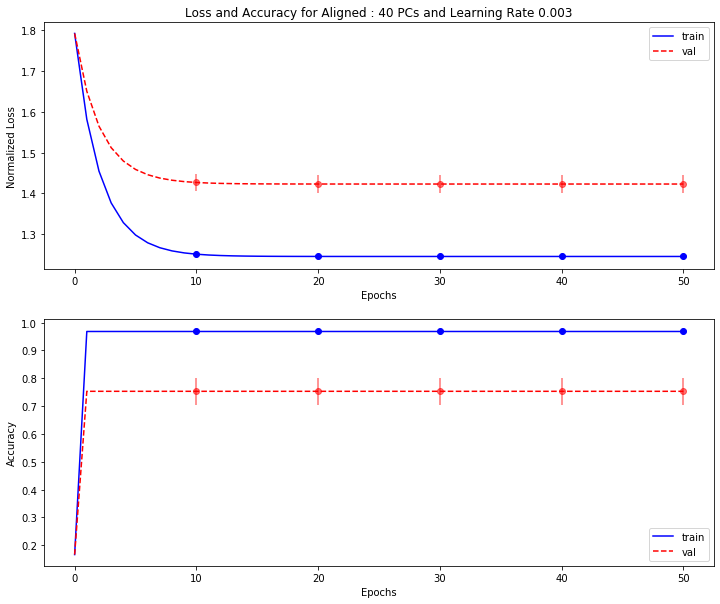

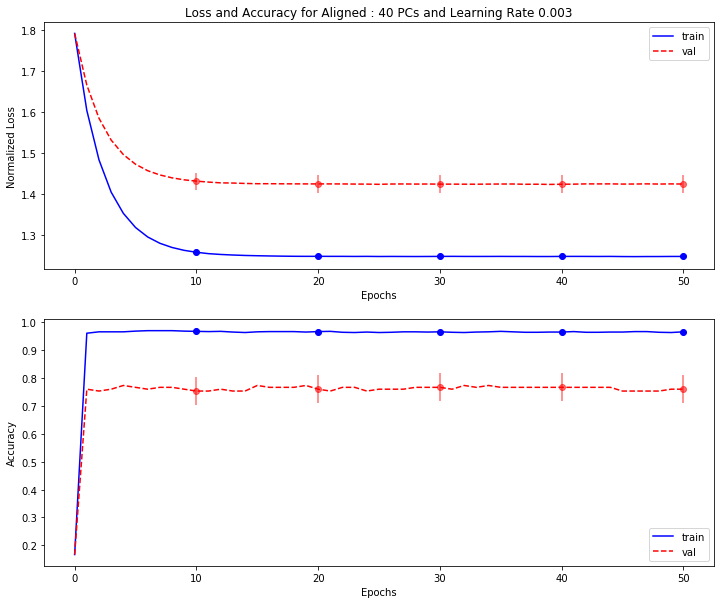

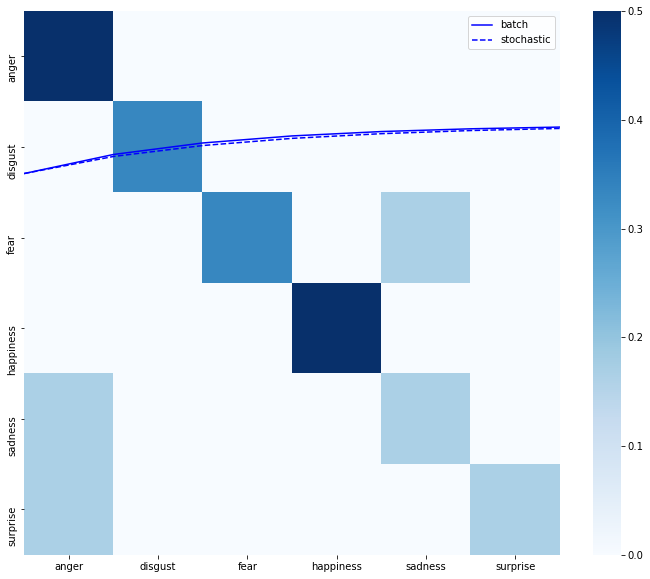

In [400]:
test, pcs = softmax_regression(40, 0.003, 10, 50)

[[-60.13373623]]
[[89.55555767]]
[[0.]]
[[209.46106552]]
[[-104.84784551]]
[[65.88092699]]
[[0.]]
[[175.74640305]]
[[-104.7538833]]
[[88.26265917]]
[[0.]]
[[266.18989533]]
[[-168.67670014]]
[[142.6376148]]
[[0.]]
[[693.83017711]]
[[-81.71695359]]
[[83.36361337]]
[[0.]]
[[215.02675875]]
[[-186.45812496]]
[[136.47945358]]
[[0.]]
[[688.66162908]]


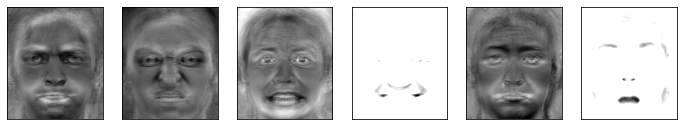

In [388]:
VisualizeWeights(test, pcs, 40, 224, 192)